In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp
import time
import random
from tqdm import tqdm
from celluloid import Camera

In [2]:
#Main variables

main_detune = 17
chirp_coeff = 15
power_rate = 1.2

figname = str(main_detune)+'_'+str(chirp_coeff)+ ', '+str(power_rate)


#Define the constants
Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 0.020/x0
v_max = 20
z_max = 382.855e-3/x0
z_start = 382.855e-3/x0
dz = 0.05/x0
dv = 0.05
v_eval = np.arange(1,26,0.5)
t_eval = np.linspace(0.,8000000.,8000001)
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3

# The detunings used in the PRAs:
intensity = 2./(np.pi*(0.020)**2)/Isat


#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(B=0,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(
    P=+1, Ahfs=-1.5/Gamma, q=0, p=0,gJ=-0.00002,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [3]:
#Define the zero magnetic field.

magField = np.zeros(3)

In [4]:
def Fixed_detune_MgF_MOT_force(times,main_det,det_coeff,pr):
    det_side = 120/Gamma
    Avg_X = np.average(E_X)
    
    init_pow = 0.15*2./(np.pi*(0.020)**2)/Isat
    power_rate = pr/(2+pr)
    
    def Heav_step(t):
        if t<6e5-7:
            return 1
        elif t>=6e5-7 and t<6e5+7:
            return (t-6e5)*((t-6e5)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0        
    
    def Chirping(t):
        return det_coeff*t*1e-6
    
    laserBeams = pylcp.laserBeams()
#Switch
#Minus sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':Heav_step(times)*init_pow*0.5*(1-power_rate),
                                                   'delta': E_A[-1]-Avg_X-main_det-det_side+Chirping(times)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':Heav_step(times)*init_pow*0.5*(1-power_rate),
                                                   'delta': E_A[-1]-Avg_X-main_det-det_side+Chirping(times)}])

#Main part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':Heav_step(times)*init_pow*power_rate,
                                                   'delta': E_A[-1]-Avg_X-main_det+Chirping(times)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':Heav_step(times)*init_pow*power_rate,
                                                   'delta': E_A[-1]-Avg_X-main_det+Chirping(times)}])
    
#Plus sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':Heav_step(times)*init_pow*0.5*(1-power_rate),
                                                   'delta': E_A[-1]-Avg_X-main_det+det_side+Chirping(times)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':Heav_step(times)*init_pow*0.5*(1-power_rate),
                                                   'delta': E_A[-1]-Avg_X-main_det+det_side+Chirping(times)}])
# #No-switch
# #Minus sideband part
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det-det_side+Chirping(t)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det-det_side+Chirping(t)}])

# #Main part
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : init_pow*power_rate,
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+Chirping(t)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : init_pow*power_rate,
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+Chirping(t)}])
    
# #Plus sideband part
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+det_side+Chirping(t)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+det_side+Chirping(t)}])

    return laserBeams

In [5]:
def Fixed_detune_MgF_MOT(main_det,det_coeff,pr):
    det_side = 120/Gamma
    Avg_X = np.average(E_X)
    
    init_pow = 0.15*2./(np.pi*(0.020)**2)/Isat
    power_rate = pr/(2+pr)
    
    def Heav_step(t):
        if t<6e5-7:
            return 1
        elif t>=6e5-7 and t<6e5+7:
            return (t-6e5)*((t-6e5)**2-49*3)*1/686*1/2 + 1/2
        else:
            return 0        
    
    def Chirping(t):
        return det_coeff*t*1e-6
    
    laserBeams = pylcp.laserBeams()
#Switch
#Minus sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*0.5*(1-power_rate),
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det-det_side+Chirping(t)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*0.5*(1-power_rate),
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det-det_side+Chirping(t)}])

#Main part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*power_rate,
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det+Chirping(t)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*power_rate,
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det+Chirping(t)}])
    
#Plus sideband part
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*0.5*(1-power_rate),
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det+det_side+Chirping(t)}])
    laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : Heav_step(t)*init_pow*0.5*(1-power_rate),
                                                   'delta': lambda t : E_A[-1]-Avg_X-main_det+det_side+Chirping(t)}])
# #No-switch
# #Minus sideband part
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det-det_side+Chirping(t)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det-det_side+Chirping(t)}])

# #Main part
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : init_pow*power_rate,
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+Chirping(t)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : init_pow*power_rate,
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+Chirping(t)}])
    
# #Plus sideband part
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':+1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+det_side+Chirping(t)}])
#     laserBeams += pylcp.laserBeams([{'kvec':np.array([0,0,-1]),'pol':-1,'pol_coord':'spherical','s':lambda R,t : init_pow*0.5*(1-power_rate),
#                                                    'delta': lambda t : E_A[-1]-Avg_X-main_det+det_side+Chirping(t)}])

    return laserBeams

In [10]:
# See solve_ivp documentation for event function discussion:
laserBeams = Fixed_detune_MgF_MOT(main_detune,chirp_coeff,power_rate)

rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)

def captured_condition(t, y, threshold=4):
    if y[-4]<4:
        val = -1.
    else:
        val = 1.

    return val
def lost_condition(t,y):
    if y[-4]>4 and y[-1]>0:
        val = -1
    elif y[-4]<0:
        val = -1
    else:
        val = 1
    return val

def for_transverse_condition(t,y):
    if y[-1]>0:
        val = -1.
    else:
        val = 1.
    return val

captured_condition.terminal=False
lost_condition.terminal=False
for_transverse_condition.terminal = False
conditions =  [captured_condition,lost_condition,for_transverse_condition]

sols_rate = list()

start = time.time()

for v0a in v_eval:
    rateeq.set_initial_position_and_velocity(np.array([0.,0.,-1*z_start]),np.array([0.,0.,v0a]))
    rateeq.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))
    
    rateeq.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= conditions,progress_bar = 1,method='LSODA')
    sols_rate.append(rateeq.sol)

Completed in 1.20 s.                                                  
Completed in 1.12 s.                                                 
Completed in 1.21 s.                                                 
Completed in 1.10 s.                                                 
Completed in 1.15 s.                                                 
Completed in 1.05 s.                                                  
Completed in 1.04 s.                                                  
Completed in 1.17 s.                                                  
Completed in 1.18 s.                                                  
Completed in 1.19 s.                                                  
Completed in 1.15 s.                                                  
Completed in 1.34 s.                                                   
Completed in 1.23 s.                                                   
Completed in 1.19 s.                                                   
Complet

In [11]:
zz = np.linspace(-1*z_max,z_max,100)
vv = np.linspace(-1*v_max,v_max+dv,100)
Z,V = np.meshgrid(zz,vv)

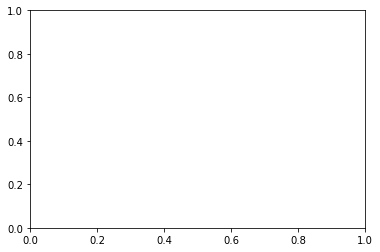

In [22]:
fig = plt.figure()
ax = fig.subplots()

camera = Camera(fig)


In [23]:
time_steps = np.linspace(0,1000000,101)

xss = np.linspace(-400,400,801)
yss = np.ones(801)*4*v0
ax.plot(xss,yss,'r')


for time_step in tqdm(time_steps):
    laserBeams = Fixed_detune_MgF_MOT_force(time_step,main_detune,chirp_coeff,power_rate)
    rateeq = pylcp.rateeq(laserBeams,magField,hamiltonian,include_mag_forces=False)
    rateeq.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='F',progress_bar=0)
    ax.imshow(rateeq.profile['F'].F[2]/mass*1e-3*a0, origin='lower',
               extent=(np.amin(zz*1000*x0), np.amax(zz*1000*x0),
                       (np.amin(vv*v0)), (np.amax(vv*v0))),
               aspect='auto',cmap='gray')
    ts = int(time_step)
    for sol in sols_rate:
        ax.plot(sol.r[2][ts]*x0*1000,sol.v[2][ts]*v0,'go')
    ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax.set_ylim(-1*max(v_eval)*v0,max(v_eval)*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    ax.set_xlabel('$z\ (\mathrm{mm})$')
    ax.set_ylabel('$v\ (\mathrm{m/s})$')
    ax.set_title('Force image')
    fig.subplots_adjust(left=0.12,right=0.9)
    camera.snap()

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [09:57<00:00,  5.91s/it]


In [24]:
ax.set_title('Force image & Motion trace')

Text(0.5, 1.0, 'Force image & Motion trace')

In [27]:
ax.plot(xss,yss,'r')

In [28]:
animation = camera.animate(interval=50, blit=False)

from IPython.display import HTML
HTML(animation.to_jshtml())

C:\Users\qmopl\anaconda3\envs\LCP\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\qmopl\anaconda3\envs\LCP\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\qmopl\anaconda3\envs\LCP\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


In [29]:
animation.save('./PR/Chirping motion trace.gif',dpi=100,writer='imagemagick')

C:\Users\qmopl\anaconda3\envs\LCP\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\qmopl\anaconda3\envs\LCP\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\qmopl\anaconda3\envs\LCP\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


In [13]:
np.tan(np.pi/12)*140

37.51288694035718